In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt


df = pd.read_csv("HRKaggleDataset.csv")
print(df.shape)
df.head()



(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Preprocessing 

In [2]:
y = df["Attrition"].map({"Yes": 1, "No": 0})


X = df.drop(columns=["Attrition", "EmployeeCount", "Over18", "StandardHours"], errors="ignore")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

Attrition
No     1233
Yes     237
Name: count, dtype: int64


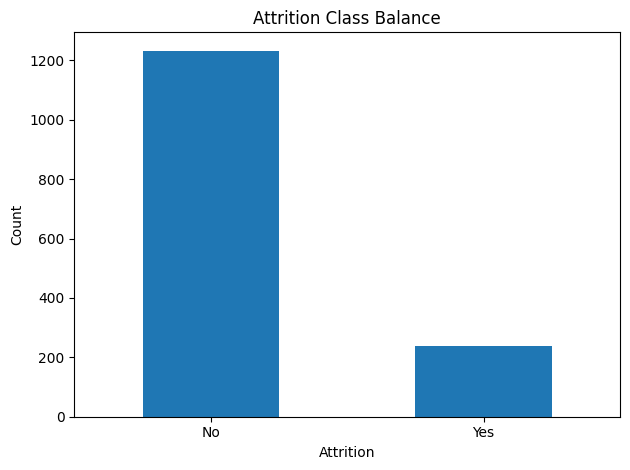

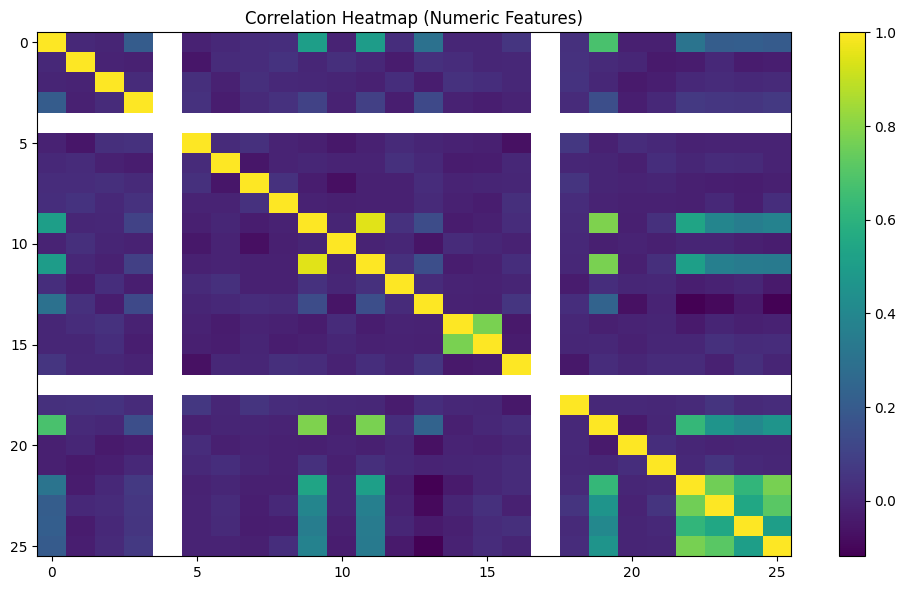

In [3]:

# class balance 

counts = df["Attrition"].value_counts()
print(counts)

plt.figure()
counts.plot(kind="bar")
plt.title("Attrition Class Balance")
plt.xlabel("Attrition")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] > 1:
    corr = num_df.corr()
    plt.figure(figsize=(10, 6))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## Model Evaluations

In [4]:
# logistic regression
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
    }

    print(f"\n=== {name} ===")
    for k in ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]:
        v = metrics[k]
        print(f"{k}: {v:.3f}" if not np.isnan(v) else f"{k}: N/A")


    plt.figure()
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No", "Yes"])
    plt.title(f"Confusion Matrix: {name}")
    plt.tight_layout()
    plt.show()


    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve: {name}")
        plt.tight_layout()
        plt.show()

    return metrics



=== Logistic Regression ===
Accuracy: 0.745
Precision: 0.341
Recall: 0.638
F1: 0.444
ROC_AUC: 0.798


<Figure size 640x480 with 0 Axes>

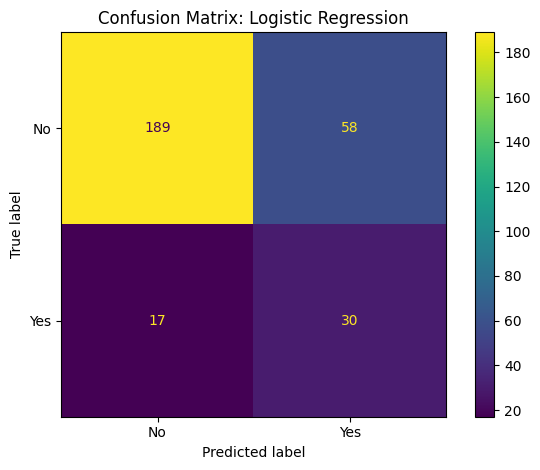

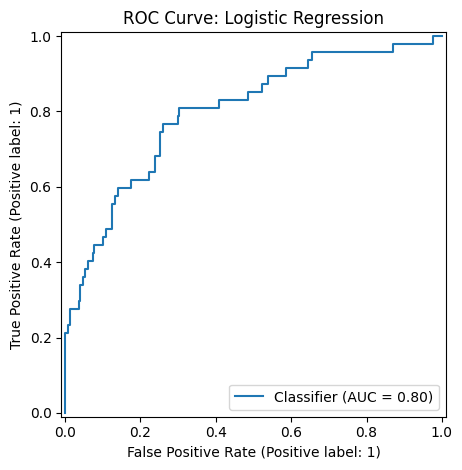

In [5]:
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

log_reg_results = evaluate_model(
    "Logistic Regression",
    log_reg,
    X_train,
    X_test,
    y_train,
    y_test
)



=== Random Forest ===
Accuracy: 0.850
Precision: 0.800
Recall: 0.085
F1: 0.154
ROC_AUC: 0.790


<Figure size 640x480 with 0 Axes>

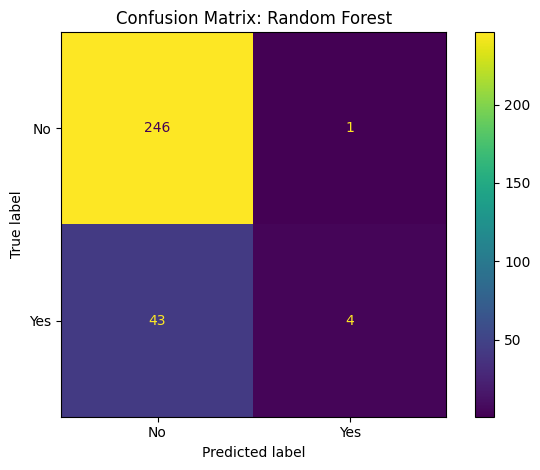

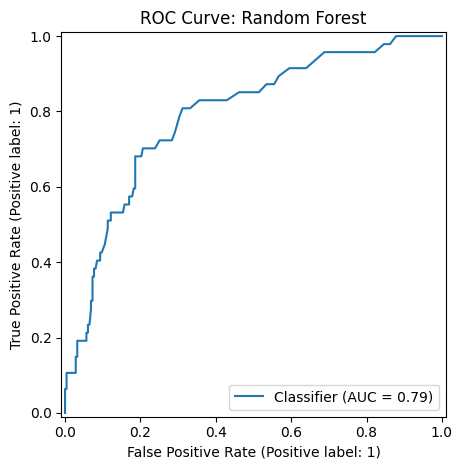

In [6]:
# random forest 

from sklearn.ensemble import RandomForestClassifier
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_results = evaluate_model(
    "Random Forest",
    rf,
    X_train,
    X_test,
    y_train,
    y_test
)


=== XGBoost ===
Accuracy: 0.864
Precision: 0.769
Recall: 0.213
F1: 0.333
ROC_AUC: 0.786


<Figure size 640x480 with 0 Axes>

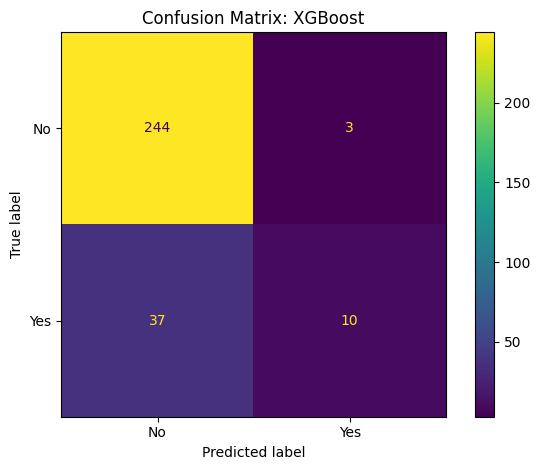

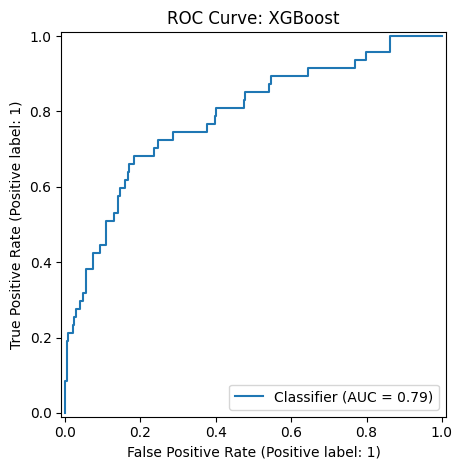

In [7]:
#Xgboost 

!pip install xgboost
from xgboost import XGBClassifier

xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

xgb_results = evaluate_model(
    "XGBoost",
    xgb,
    X_train,
    X_test,
    y_train,
    y_test
)


In [8]:
# compared results 

results_df = pd.DataFrame([
    log_reg_results,
    rf_results,
    xgb_results
])

results_df

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.744898,0.340909,0.638298,0.444444,0.797829
1,Random Forest,0.850340,0.800000,0.085106,0.153846,0.790335
2,XGBoost,0.863946,0.769231,0.212766,0.333333,0.785511


In [9]:
# feature importance interpretation

results_df


rf_pipeline = rf 
rf_pipeline.fit(X_train, y_train)

ohe = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_cols, cat_feature_names])


importances = rf_pipeline.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


feature_importance_df.head(15)


,Feature,Importance
10,MonthlyIncome,0.065387
0,Age,0.060171
1,DailyRate,0.049635
17,TotalWorkingYears,0.049479
4,EmployeeNumber,0.044250
20,YearsAtCompany,0.042412
23,YearsWithCurrManager,0.041030
6,HourlyRate,0.040927
11,MonthlyRate,0.040143
2,DistanceFromHome,0.039446


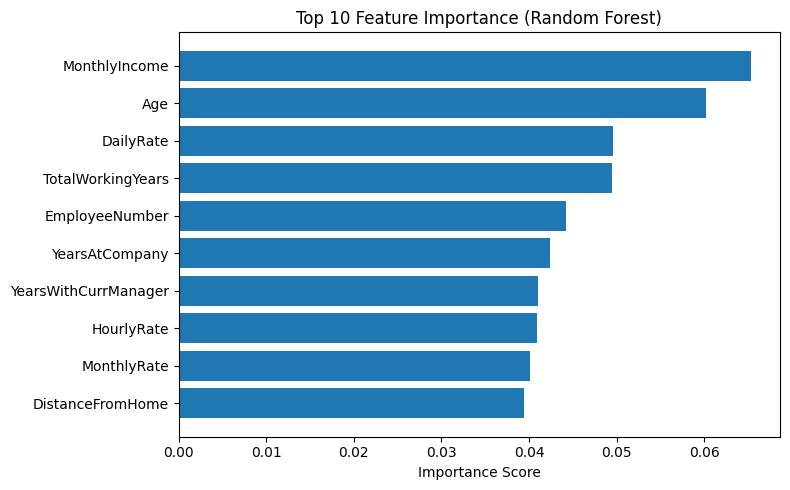

In [10]:
# top 10 features
top_features = feature_importance_df.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
